# De Gregorio et al. (2021)<br/> **Lemur *Indri indri***

**Paper:** De Gregorio, C., Valente, D., Raimondi, T., Torti, V., Miaretsoa, L., Friard, O., Giacoma, C., Ravignani, A., & Gamba, M. (2021). Categorical rhythms in a singing primate. Current Biology, 31(20), R1379–R1380. https://doi.org/10.1016/j.cub.2021.09.032

**Dataset:** Available from first author upon request.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from src.intervals import report_intervals, save_intervals, load_intervals, drop_na
from src.motifs import ngram_motifs, normalize, string_motifs 
from src.plotting import rhythm_plot, show_integer_ratios, ternary_motif_plot

## Preprocess data

Background from article:

"We focused on one of the few singing primates, the lemur Indri indri (Figure 1B), sampling approximately 1% of all living individuals from this critically endangered species (for details, see Supplemental information, published with this article online). All members of a family group sing in temporally coordinated duets and choruses (see: https://youtu.be/wxVYsAodZ6U)7,8. Over 12 years, we recorded songs from 20 indri groups (39 individuals) living in their natural habitat, the rainforest of Madagascar. We extracted temporal features of indris’ songs, analyzing inter-onset intervals (Fig"

From the supplements:

"We then labeled the silent portions of the individual contributions, differentiating silences depending on whether they occurred between two notes of the same phrase, vs. between two different phrases or two different isolated notes. For each of the above units and intervals, we extracted the timing of note onsets and duration usin Praat. We imported them in R (R Core Team 2017; version 3.4.3) and calculated the inter-onset intervals (tk, Figure 1C) based on onsets to evaluate the rhythmic structure of contributionsS11. Based on previous workS7,S12, we used the information on notes and silences type (belonging to a phrase or an isolated note) to calculate two types of tk. The within-phrase tk (WP: Within-Phrase inter-onset intervals) are all and only the intervals between notes within a phrase (roughly mapping to the two leftmost peaks in Figure 1E). The between-phrase tk (BP: Between-Phrase inter-onset intervals) are all and only the intervals between two different phrases or between two isolated notes (roughly mapping to the two rightmost peaks in Figure 1E). Note that a sequence of n notes will produce n-1 inter-onset intervals, i.e. t1,...,tn-1."

"We then calculated rhythmic ratios rk following the methodology of Roeske et al.S13, namely by dividing each tk for its duration plus the duration of the following interval: rk = tk /(tk+tk+1). Since each tk can either be a WP or a BP, we obtained four ratio types: WP/(WP+WP), WP/(WP+BP), BP/(WP+BP) and BP/(BP+BP), depending on the type of two adjacent tk."

In [7]:
# Load and clean up the dataframe
df = pd.read_csv(
    'data/degregorio2021/De_Gregorio_et_al_DATA_intervals.csv', 
    delimiter=';', decimal=",", index_col=0)

# Labels are duplicated, drop those
# there's only one exception---maybe that's an error?
# I assume intra = 'witin phrase/WP' and inter = 'between phrase/BP'
assert len(df.query('label1=="intra-DP" and label2=="inter-DP"')) == 1
df['label'] = df['labelwp']
unique_labels = df[['label1', 'labelwp', 'label2', 'label3', 'label4', 'item_order']].drop_duplicates()
assert len(unique_labels) == 3
df.drop(columns=['label1', 'label2', 'label3', 'label4', 'item_order', 'labelwp'], inplace=True)

# Drop empty/constant columns
assert df['note_order'].isna().all()
assert df['item_notetype'].isna().all()
assert (df['age'] == 'Adult').all()
assert (df['age,class'] == 'Adult').all()
assert (df['exc_roar'] == 1).all()
assert (df['exc_intervals'] == 0).all()
df.drop(columns=['note_order', 'item_notetype', 'age,class', 'age', 'exc_roar', 'exc_intervals'], inplace=True)

# Save and then drop files
files = df[['file', 'id_phrase']].copy()
df.drop(columns=['file', 'id_phrase'], inplace=True)

# Singers
# `ID_ind` is presumably the name of the individual, which corresponds to `id_singer`. 
# Every singer has multiple contributions (`id_contribution`).
singers = (
    df[['ID_Ind', 'id_singer', 'sex']]
        .drop_duplicates()
        .reset_index()
        .drop(columns=['xx'])
        .set_index('id_singer')
        .sort_index()
    )

# Songs have multiple contributors:
assert len(df['id_contribution'].unique()) > len(df['id_song'].unique())

# Check monotonicity
assert (df['X'].sort_values() == df['X']).all()

# Hope this makes sense...
df['end'] = df['start'] + df['duration']

df = df.reindex(columns=[
    'X', # What is this? Monotonically increasing in any case
    'nu', # What is this? 
    'order', # What is this? More or less corresponds to X
    'start', 
    'duration',
    'end', # start + duration, manual addition
    'label', # Either 'intra' or 'inter'
    'n_of_intervals', 
    'id_song',
    'id_group', # Corresponds to id_song
    'id_singer', 
    'id_contribution', # Multiple per singer
    'ID_Ind', 
    'sex', 
])

# df.to_csv('intervals/degregorio2021/degregorio2021-data.csv')

In [8]:
df

,X,nu,order,start,duration,end,label,n_of_intervals,id_song,id_group,id_singer,id_contribution,ID_Ind,sex
xx,,,,,,,,,,,,,,
1,11,0,11,11.808,0.969,12.777,intra,67,1,1,12,1,Bevolo,F
2,13,0,13,14.051,1.749,15.800,inter,67,1,1,12,1,Bevolo,F
3,15,0,15,16.738,0.936,17.674,intra,67,1,1,12,1,Bevolo,F
4,17,0,17,18.954,2.772,21.726,inter,67,1,1,12,1,Bevolo,F
5,19,0,19,22.797,0.845,23.642,intra,67,1,1,12,1,Bevolo,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16145,42286,2,406,264.866,0.824,265.690,intra,75,279,12,36,600,Mamatin,F
16146,42288,2,408,266.970,4.240,271.210,inter,75,279,12,36,600,Mamatin,F
16147,42290,2,410,272.146,0.792,272.938,intra,75,279,12,36,600,Mamatin,F


There are multiple singers (with a unique `id_singer`) contributing to each song (unique `song_id`). 
So if we take the `start` values for a single contribution (`id_contribution`), then we get sequence of vocalization onsets (their their durations are in the column `duration`). 
The types are then determined from the labels "intra` and "inter", which correspond to the within-phrase/WP and between-phrase/BP in the supplements.

In [10]:
from src.motifs import separate_sequences

In [13]:
ints = (df['start'][1:] - df['start'][:-1])/

In [15]:
len(df)

14044

In [16]:
len(ints)

14044

In [12]:
separate_sequences(df, column='id_contribution')

,X,nu,order,start,duration,end,label,n_of_intervals,id_song,id_group,id_singer,id_contribution,ID_Ind,sex
0,11.0,0.0,11.0,11.808,0.969,12.777,intra,67.0,1.0,1.0,12.0,1.0,Bevolo,F
1,13.0,0.0,13.0,14.051,1.749,15.800,inter,67.0,1.0,1.0,12.0,1.0,Bevolo,F
2,15.0,0.0,15.0,16.738,0.936,17.674,intra,67.0,1.0,1.0,12.0,1.0,Bevolo,F
3,17.0,0.0,17.0,18.954,2.772,21.726,inter,67.0,1.0,1.0,12.0,1.0,Bevolo,F
4,19.0,0.0,19.0,22.797,0.845,23.642,intra,67.0,1.0,1.0,12.0,1.0,Bevolo,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14666,42288.0,2.0,408.0,266.970,4.240,271.210,inter,75.0,279.0,12.0,36.0,600.0,Mamatin,F
14667,42290.0,2.0,410.0,272.146,0.792,272.938,intra,75.0,279.0,12.0,36.0,600.0,Mamatin,F
14668,42292.0,2.0,412.0,274.338,4.144,278.482,inter,75.0,279.0,12.0,36.0,600.0,Mamatin,F
14669,42294.0,2.0,414.0,279.738,0.904,280.642,intra,75.0,279.0,12.0,36.0,600.0,Mamatin,F


In [3]:
intervals = []
labels = []
for contrib_id in df['id_contribution'].unique():
    # Corresponds to a single song and singer
    subset = df.query(f'id_contribution=={contrib_id}')
    assert len(subset['id_song'].unique()) == 1
    assert len(subset['id_singer'].unique()) == 1
    ints = subset['start'].values[1:] - subset['start'].values[:-1]
    intervals.extend(ints)
    intervals.append(np.nan)
    labs = subset['label'].values[:-1]
    labels.extend(labs)
    labels.append(None)    
intervals = np.array(intervals)
labels = np.array(labels)
assert len(labels) == len(intervals)

# Save intervals and labels
# save_intervals(intervals, 'degregorio2021', 'degregorio2021')
# ints_df = pd.DataFrame([intervals, labels], index=['interval', 'label']).T
# ints_df.to_csv('intervals/degregorio2021/degregorio2021-intervals-labels.csv', index=False)

## Plot

In [4]:
df = pd.read_csv('intervals/degregorio2021/degregorio2021-intervals-labels.csv')
intervals = load_intervals('degregorio2021', 'degregorio2021')

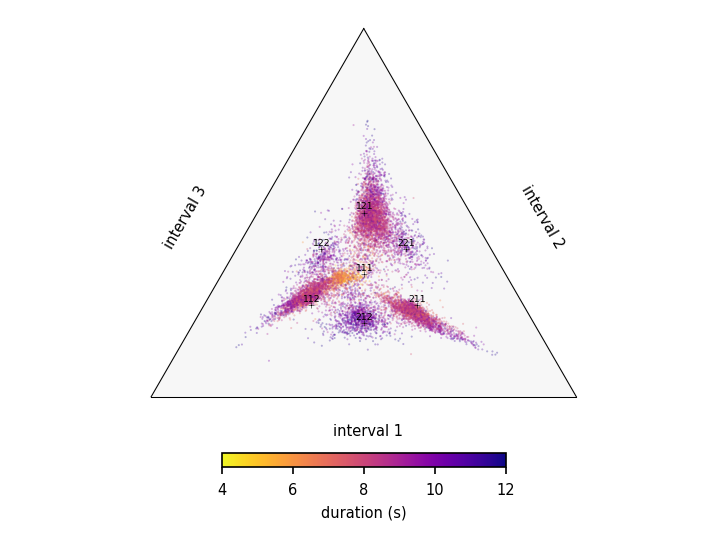

In [5]:
motifs, duration = normalize(ngram_motifs(intervals, length=3))
ternary_motif_plot(motifs, duration, min_dur=4, max_dur=12, ratio_kws=dict(factors=[1, 2]))

# plt.savefig('figures/degregorio2021/degregorio2021-motifs.pdf')
# plt.savefig('figures/degregorio2021/degregorio2021-motifs.png', dpi=150)

(<Figure size 900x600 with 2 Axes>,
 TernaryAxesSubplot: 301917873,
 <matplotlib.colorbar.Colorbar at 0x10a52b2d0>)

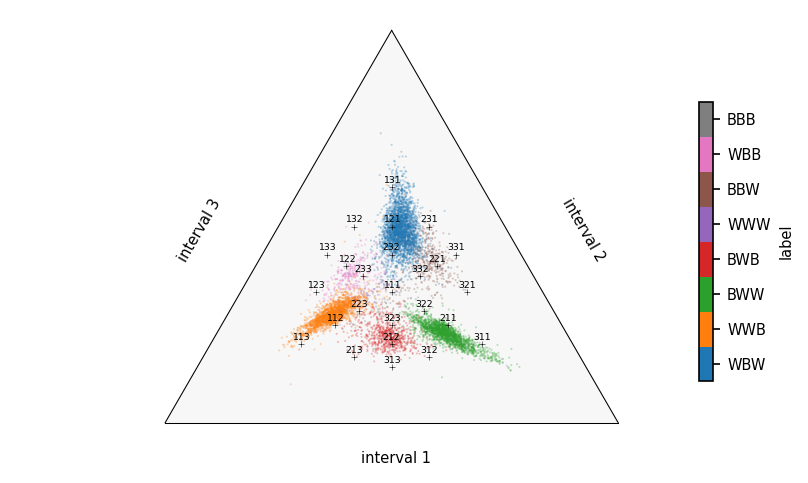

In [5]:
motifs, duration = normalize(ngram_motifs(intervals, length=3))
labels = string_motifs(df['label'], 3, aggregator=dict(intra='W', inter='B'), sep='')
ternary_motif_plot(motifs, duration, labels=labels)

# plt.savefig('figures/degregorio2021/degregorio2021-motifs-by-type.pdf')
# plt.savefig('figures/degregorio2021/degregorio2021-motifs-by-type.png', dpi=150)

In [6]:
df

,interval,label
0,2.243,intra
1,2.687,inter
2,2.216,intra
3,3.843,inter
4,1.940,intra
...,...,...
14039,2.104,intra
14040,5.176,inter
14041,2.192,intra
14042,5.400,inter


In [ ]:
motifs, duration = normalize(ngram_motifs(intervals, length=3))
ternary_motif_plot(motifs, duration, min_dur=4, max_dur=12, ratio_kws=dict(factors=[1, 2]))

# plt.savefig('figures/degregorio2021/degregorio2021-motifs.pdf')
# plt.savefig('figures/degregorio2021/degregorio2021-motifs.png', dpi=150)